<a href="https://colab.research.google.com/github/Johansmm/RT-multiperson-pose-pytorch/blob/imt-atlantique/pose_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning project
Intro by Tatiana

In [3]:
# Libraries
# Colab libraries
from google.colab import drive
from google.colab import output
drive.mount('/content/gdrive')
colab_path = "/content/gdrive/My Drive/Colab Notebooks/"

# Basis libraries
import os, re, sys, math, time, scipy, argparse
import cv2, matplotlib
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage.filters import gaussian_filter, maximum_filter

Mounted at /content/gdrive


## Section 0: Download and install repository
First, we will download the repository that we copied from the [original repository](https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation) in order to make some changes for educational purposes. Then, we install libraries and some dependences explained in the original repository.

In [4]:
# Independence install
!sudo apt-get install swig
%cd $colab_path
if not os.path.isdir("RT-multiperson-pose-pytorch"):
  # Repository clone
  !git clone https://github.com/Johansmm/RT-multiperson-pose-pytorch.git
  %cd "RT-multiperson-pose-pytorch"
  %cd lib/pafprocess 
  # Repository compile
  !sh make.sh

# Libraries install
%cd $colab_path"/RT-multiperson-pose-pytorch"
!python -m pip install -r ./requirements.txt
!git submodule init && git submodule update
# Weights download
if not os.path.isfile("./pose_model.pth"):
  !wget https://www.dropbox.com/s/ae071mfm2qoyc8v/pose_model.pth
output.clear()
print("[INFO]: Proyect uploaded successfully")

[INFO]: Proyect uploaded successfully


In [ ]:
!python demo/picture_demo.py

Bulding VGG19
0.5459940652818991


In [6]:
# Framework libraries
%cd $colab_path"/RT-multiperson-pose-pytorch"
sys.path.append('.')
from lib.network.rtpose_vgg import get_model
from lib.network import im_transform
from lib.utils.common import Human, BodyPart, CocoPart, CocoColors, CocoPairsRender, draw_humans
from lib.utils.paf_to_pose import paf_to_pose_cpp
from lib.config import cfg, update_config
from evaluate.coco_eval import get_outputs, handle_paf_and_heat, run_eval

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch


## Section 2: Replication of results
In this section we replicated some resutls. First, we need download the data. For this case, we will use the `sh` compiler provided by [original repository](https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation)

In [7]:
%cd $colab_path"/RT-multiperson-pose-pytorch"
data_download = False # For download COCO dataset
if data_download and not os.path.isdir("data/coco"):
  !mkdir data
  %cd data
  !sh ../lib/datasets/CocoDataDownloader.sh
  %cd $colab_path"/RT-multiperson-pose-pytorch"
  output.clear()
  print("[INFO]: Coco database downloaded successfully")

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch


Now, we defined some principal functions.

In [8]:
%cd $colab_path"/RT-multiperson-pose-pytorch"
class Namespace:
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

def load_rtpose_model():
  args = Namespace(cfg = './experiments/vgg19_368x368_sgd.yaml', weight = 'pose_model.pth', opts = [])
  update_config(cfg, args)
  model = get_model('vgg19')     
  model.load_state_dict(torch.load(args.weight))
  model = torch.nn.DataParallel(model).cuda()
  model.float()
  model.eval()
  return model

def im_forward(image, model):
  with torch.no_grad():
    paf, heatmap, im_scale = get_outputs(image, model, 'rtpose')
  return paf, heatmap, im_scale

model = load_rtpose_model()

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch
Bulding VGG19


['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_get_uidx', 'add_pair', 'body_parts', 'get_face_box', 'get_max_score', 'get_upper_body_box', 'is_connected', 'merge', 'pairs', 'part_count', 'score', 'uidx_list']
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_get_uidx', 'add_pair', 'body_parts', 'get_face_box', 'get_max_score', 'get_upper_body_box', 'is_connected', 'merge', 'pairs', 'part_count', 'score', 'uidx_list']
['__class_

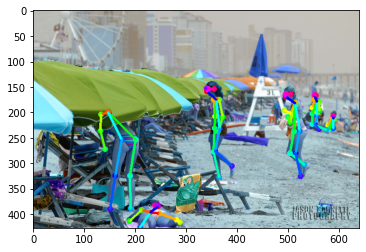

In [8]:
image = cv2.imread('./data/coco/images/train2017/000000000315.jpg')
paf, heatmap, im_scale = im_forward(image, model)
humans = paf_to_pose_cpp(heatmap, paf, cfg)
for hum in humans:
  print(dir(hum))

out = draw_humans(image, humans)
plt.imshow(out)

In [9]:
run_eval(image_dir= './data/coco/images/val2017', 
         anno_file = './data/coco/annotations/annotations/person_keypoints_val2017.json', 
         vis_dir = './data/coco/images/vis_val2017', model=model, preprocess='vgg')

loading annotations into memory...
Done (t=1.45s)
creating index...
index created!
Total number of validation images 2693
Processing Images in validation set
Processed 10 images
Processed 20 images
Processed 30 images
Processed 40 images
Processed 50 images
Processed 60 images
Processed 70 images
Processed 80 images
Processed 90 images
Processed 100 images
Processed 110 images
Processed 120 images
Processed 130 images
Processed 140 images
Processed 150 images
Processed 160 images
Processed 170 images
Processed 180 images
Processed 190 images
Processed 200 images
Processed 210 images
Processed 220 images
Processed 230 images
Processed 240 images
Processed 250 images
Processed 260 images
Processed 270 images
Processed 280 images
Processed 290 images
Processed 300 images
Processed 310 images
Processed 320 images
Processed 330 images
Processed 340 images
Processed 350 images
Processed 360 images
Processed 370 images
Processed 380 images
Processed 390 images
Processed 400 images
Processed 4

0.09069277022672843

In [ ]:
# Colab libraries
from google.colab import drive
from google.colab import output
drive.mount('/content/gdrive')

%cd "/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch"
!git config --global user.email "johan-steven.mejia-mogollon@imt-atlantique.com"
!git config --global user.name "Johansmm"
!git remote set-url origin "https://github.com/Johansmm/RT-multiperson-pose-pytorch.git"
# !git commit -am "Updating in colab"
# !git reset --hard
!git pull origin imt-atlantique
# !git push origin imt-atlantique

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch
[master a24c440] Updating in colab
From https://github.com/Johansmm/RT-multiperson-pose-pytorch
 * branch            imt-atlantique -> FETCH_HEAD
Already up to date.
